In [1]:
import sys
sys.path.append('C:\\PYTHONprojects\\en')
sys.path.append('C:\\PYTHONprojects')
sys.path.append('C:\\PYTHONprojects\\utilities')
import morePVs_output as opm
import morePVs as mpv
import os
import en_utilities as um
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
base_path='C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\studies'
project='EN2_bat2'



Plotting npv vs kWp and kWh storage
----------------------------------------------------------------



 


In [3]:
# Set up constants
sites = ['A','E',  'D','B', 'H', 'I', 'G', 'C',  'J', 'F' ]
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ordered_sites = dict(zip(sites,values))
tag_list = ['a208_f12_cp34',
 'a161_f7_cp38',
 'a138_f9_cp44',
 'a104_f8_cp57',
 'a52_f3_cp26',
 'a48_f4_cp09',
 'a44_f4_cp17',
 'a34_f4_cp33',
 'a26_f4_cp43',
 'a20_f5_cp36']

tag_dict = \
{'A': 'a208_f12_cp34',
 'B': 'a104_f8_cp57',
 'C': 'a34_f4_cp33',
 'D': 'a138_f9_cp44',
 'E': 'a161_f7_cp38',
 'F': 'a20_f5_cp36',
 'G': 'a44_f4_cp17',
 'H': 'a52_f3_cp26',
 'I': 'a48_f4_cp09',
 'J': 'a26_f4_cp43'}
tag_sorter= dict(zip(tag_list,values))


# Plotting set-up parameters
cmap = mpl.cm.tab10_r
alpha=1
sites_grouped={'all': sites,
              'group1': [s for s in sites if s in ['A','B','C','D','E']],
              'group2': [s for s in sites if s in['F', 'G','H','I','J']]}
sites = sites_grouped['group2']
#a_terms =[a for a in [5,10,15,20,25] if a in df.a_term.tolist()]
a_terms =[10,20]
# dashList = [(2,8),(3,5),(10,0),(3,2,10,2),(5,2,20,2)] 
# markers =['+','o','d','s','x']
# term_dashes = dict(zip(a_terms,dashList))
# term_markers = dict(zip(a_terms,markers))

# get pv sizes for maximum pv systems
maximums={}
pv_ref_file='C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_3\\reference\\capex_pv_lookup.csv'
pv_ref=pd.read_csv(pv_ref_file)
pv_ref = pv_ref.set_index('pv_cap_id')
for i in pv_ref.index:
    if 'max' in i and 'site' in i:
        site = um.find_between(i,'_','_')
        maximums[site] = pv_ref.loc[i,'kW']

        
# These need updating:
#capexes= [c for c in ['capex_low','capex_med','capex_high']if c in df.en_capex_id.tolist()]
capexes= ['capex_low','capex_med','capex_high']
#parents = [p for p in ['EA310_12c_FIT8', 'EA310_12c_FIT12', 'EA310_12c',\
#           'EA310_10c_FIT8', 'EA310_10c_FIT12', 'EA310_10c',\
#         'EA310_8c_FIT8', 'EA310_8c_FIT12','EA310_8c'] if p in df.parent.tolist()]
# parents_retail = list(set([p[6:] for p in df.parent.tolist() if p != 'TIDNULL']))

In [5]:

sites = ['F','G','H','I','J']   
# ---------------------------------------------------
# combine  input and result files, add new parameters
# ---------------------------------------------------

for site in sites:
    study='finance2_' + site 
    infile = os.path.join(base_path, project, 'inputs' , 'study_'+study+ '.csv')
    resultsfile = os.path.join(base_path, project, 'outputs' ,study, study+'_results.csv')
    df_in = pd.read_csv(infile)
    df_in = df_in.set_index('scenario')
    df_r = pd.read_csv(resultsfile)
    df_r = df_r.set_index('scenario')                              
    df = df_r.merge(df_in,left_index = True, right_index=True)
    for c in df.columns:
        if '_x' in c:
            nc = c[:-2]
            df.rename(columns={c:nc}, inplace=True)
        if '_y' in c:
            df= df.drop([c],axis=1)
    
    
    # get kWp / unit , total $ / unit  and npv cf bau for each scenario
    # -----------------------------------------------------------------
    df['pv_filename'].fillna('zero',inplace=True)
    df['central_battery_capacity_kWh'].fillna(0, inplace=True)
    df['site'] = df['load_folder'].apply(lambda x: x[-1])
    for s in df.loc[df['arrangement'] != 'bau'].index:
        
        parent = df.loc[s, 'parent']
    
        capex= df.loc[s,'en_capex_id']
        a_term = df.loc[s,'a_term']

        df.loc[s,'site_tag']= tag_dict[df.loc[s,'site']]
        if df.loc[s,'pv_filename'] == 'zero':
            df.loc[s,'kWp_unit'] =0
        elif 'max' in df.loc[s,'pv_filename']:
            df.loc[s,'kWp_unit']= maximums[site]/df.loc[s,'number_of_households']
        else:
            df.loc[s,'kWp_unit'] = float(df.loc[s,'pv_filename'][-9]) + float(df.loc[s,'pv_filename'][-7])/10 
        df.loc[s,'kWh_unit']= df.loc[s,'central_battery_capacity_kWh']/df.loc[s,'number_of_households']
        df.loc[s,'npv_unit'] = df.loc[s,'eno$_npv_building_mean']/df.loc[s,'number_of_households']
        df.loc[s,'npv_unit_pa'] = df.loc[s,'npv_unit']/a_term
        bau_scenario = df[(df['site']==site) & (df['arrangement'] == 'bau') & (df['a_term'] == a_term)].index
        en_scenario = df[(df['site']==site) & (df['arrangement'] == 'en') & (df['a_term'] == a_term) & \
                          (df['kWp_unit']==0) & (df['parent'] == parent) & \
                         (df['en_capex_id']==capex)].index
        df.loc[s,'bau_npv'] = (df.loc[bau_scenario,'eno$_npv_building_mean']).values[0]/df.loc[s,'number_of_households']
        df.loc[s,'bau_npv_pa'] = df.loc[s,'bau_npv']/a_term
        df.loc[s,'npv_cf_bau'] = df.loc[s,'npv_unit_pa'] - df.loc[s,'bau_npv_pa']
                      
        df.loc[s,'en_npv'] = (df.loc[en_scenario,'eno$_npv_building_mean']).values[0]/df.loc[s,'number_of_households']
        df.loc[s,'en_npv_pa'] = df.loc[s,'en_npv']/a_term
        df.loc[s,'en_cf_bau'] = df.loc[s,'en_npv_pa'] - df.loc[s,'bau_npv_pa']
    df['parent_retail']= df.loc[df['parent'] != 'TIDNULL']['parent'].apply(lambda x: x[6:])
    

    fileout =  os.path.join(base_path, project, 'outputs' ,study, study+'_results_process.csv')
    um.df_to_csv(df,fileout)

    
    

In [6]:
arrangement = 'en_pv'
fontsize=12

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\studies\\EN2_bat2\\outputs\\finance2_G\\plots\\npv_2d\\npv_kWh_site_G_en_pv_ch_ed1600_s_cmax_1000.0_capex_med_20.0_TOU12.jpg'

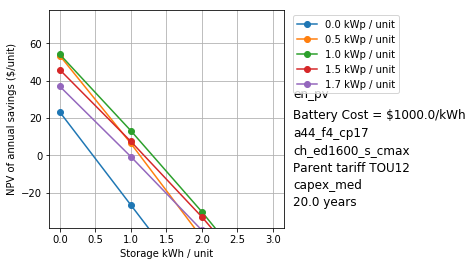

In [13]:
for site in sites:
    # Reload processed results:
    # ------------------------
    study='finance2_'+ site 
    fileout =  os.path.join(base_path, project, 'outputs' ,study, study+'_results_process.csv')
    df = pd.read_csv(fileout)
    df = df.set_index('scenario')


    # Drop 'bau' scenario:
    df = df.loc[df['arrangement'].isin(['en', 'en_pv'])]

    # Directories for plots
    # ---------------------
    plot_path= os.path.join(base_path, project, 'outputs' ,study,'plots')
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    plot_npv_2d= os.path.join(plot_path,'npv_2d')
    if not os.path.exists(plot_npv_2d):
        os.makedirs(plot_npv_2d)
    plot_npv_3d= os.path.join(plot_path,'npv_3d')
    if not os.path.exists(plot_npv_3d):
        os.makedirs(plot_npv_3d)

    # ------------------------
    # prep and plot NPV cf BAU
    # ------------------------
    maxNPV = df['npv_cf_bau'].max().max()*1.2
    minNPV = - maxNPV/2


    # Fill null battery:
    battery_fields = [c for c in df.columns if 'battery_id' in c]
    for c in battery_fields:
        df[c] = df[c].fillna(0)
    df['kWh_unit'].fillna(0,inplace=True)
    
    
    # label battery and PV scenarios:
    df.loc[:,'kWp_str'] = df.loc[:,'kWp_unit'].apply(lambda x : str(round(x,2)))
    df.loc[:,'a_term_str'] = df.loc[:,'a_term'].apply(lambda x : str(round(x,0)))
    df.loc[:,'kWh_str'] = df.loc[:,'kWh_unit'].apply(lambda x : str(round(x,2)))
    df['combined'] = df['site']+ '_' + \
                    df['arrangement'] + \
                    '_'+ df['kWp_str'] + \
                    '_'+ df['a_term_str'] + \
                    '_' + df['kWh_str']
    # Identify zero battery scenarios
    df_nobat = df[df['kWh_unit']==0]
    
    # Select data
    # -----------
    for cost_kWh in df['battery_capex_per_kWh'].drop_duplicates().dropna().values:
        for strategy in df['central_battery_strategy'].drop_duplicates().dropna().values:
            for capex in df['en_capex_id'].drop_duplicates().dropna().values:
                for a_term in df['a_term'].drop_duplicates().values:
                    for parent_retail in df['parent_retail'].drop_duplicates().dropna().values:


                        #Slice for variables
                        dfc = df.loc[(df['battery_capex_per_kWh']==cost_kWh) & \
                                    (df['central_battery_strategy'] == strategy) & \
                                    (df['en_capex_id'] == capex) & \
                                    (df['a_term'] == a_term) & \
                                    (df['parent_retail'] == parent_retail)] \
                        .append(
                                     df_nobat.loc[(df_nobat['en_capex_id'] == capex) & \
                                    (df_nobat['a_term'] == a_term) & \
                                    (df_nobat['parent_retail'] == parent_retail)], sort=True)

                        dfx = dfc.copy()
                        npv_en_only = dfx['en_cf_bau'].values[0]


                        dfx = dfx.drop_duplicates('combined')
    #     dfx['kWp_kWh'] =  dfx['kWp_str'] + '_'+ dfx['kWh_str']
    #     dfx['new_label']= dfx['site_tag']+ '_'+ dfx['kWp_str'] + '_'+ dfx['aterm_str']


                        # ----------------------
                        # reindex and stack data
                        # ----------------------
                        dfx.index = [dfx.kWh_unit,dfx.kWp_unit]
                        dfu = dfx['npv_cf_bau'].unstack()
                        dfv=dfu.transpose()
                        # NB - parent, capex combinations must have sufficient data
                        # if (dfv.shape[0] <= 1 or dfv.shape[1] <= 1):
                        #     continue

                        # ---------------------
                        # Plot %BAU vs kW peak
                        # ---------------------
                        dfplot = dfv.copy()
                        cols = dfplot.columns
                        cols2 = [str(round(c,1)) + ' kWh / unit' for c in cols]
                        dfplot.columns = cols2
                        fig, ax = plt.subplots()
                        # Legend outside box and resize chart to fit
                        box = ax.get_position()
                        ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
                        dfplot.plot(ax=ax,kind='line',grid=True, marker = 'o').legend(loc = 'upper left',bbox_to_anchor=(1.02, 1))

                        ax.set_ylim(minNPV,maxNPV)
                        ax.set_ylabel('NPV of annual savings ($/unit)')
                        ax.set_xlabel('PV kWp / unit')

                        # Label Parameters
                        # ----------------
                        pa = arrangement
                        pt = tag_dict[site]
                        ps = strategy
                        pc = 'Battery Cost = $'+ str(cost_kWh) + '/kWh'
                        pp = 'Parent tariff '+ parent_retail
                        pcap = capex
                        pterm = str(a_term) + ' years'
                        ax.text(1.04,0.6,pa,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.5,pc,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.42,pt,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.34,ps,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.26,pp,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.18,pcap,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.1,pterm,transform=ax.transAxes,fontsize=fontsize)

                        pname = 'npv_kWp'  +'_'+ 'site_' + \
                            site + '_'+ \
                            arrangement+ '_' + \
                            strategy +'_' + \
                            str(cost_kWh) + '_' + \
                            capex + '_' + \
                            str(a_term) + '_' + \
                            parent_retail + '.jpg'
                        plotFile = os.path.join(plot_npv_2d,pname)
                        plt.savefig(plotFile,dpi=1000)
                        plt.close()

                        # -----------------
                        # Plot %BAU vs kWh 
                        # -----------------
                        dfplot = dfv.copy().T
                        cols = dfplot.columns
                        cols2 = [str(round(c,1)) + ' kWp / unit' for c in cols]
                        dfplot.columns = cols2
                        fig, ax = plt.subplots()
                        # Legend outside box and resize chart to fit
                        box = ax.get_position()
                        ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
                        dfplot.plot(ax=ax,kind='line',grid=True, marker = 'o').legend(loc = 'upper left',bbox_to_anchor=(1.02, 1))

                        ax.set_ylim(minNPV,maxNPV)
                        ax.set_ylabel('NPV of annual savings ($/unit)')
                        ax.set_xlabel('Storage kWh / unit')

                        # Label Parameters
                        # ----------------
                        ax.text(1.04,0.6,pa,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.5,pc,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.42,pt,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.34,ps,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.26,pp,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.18,pcap,transform=ax.transAxes,fontsize=fontsize)
                        ax.text(1.04,0.1,pterm,transform=ax.transAxes,fontsize=fontsize)

                        pname = 'npv_kWh' +'_'+ 'site_'+ \
                            site + '_'+ \
                            arrangement+ '_' + \
                            strategy +'_' + \
                            str(cost_kWh) + '_' + \
                            capex + '_' + \
                            str(a_term) + '_' + \
                            parent_retail + '.jpg'
                        plotFile = os.path.join(plot_npv_2d,pname)
                        plt.savefig(plotFile,dpi=1000)
                        plt.close()

                        # ------------------------------------------------------------------------

                        # ------------------------------
                        # Plot 3D %BAU vs kW peak and kWh 
                        # ------------------------------
                        dfplot = dfv.copy()
                        x = dfplot.columns
                        y = dfplot.index
                        X,Y = np.meshgrid(x,y)
                        Z = dfplot
                        
                        fig = plt.figure()
                        ax = fig.add_subplot(111, projection='3d')
                        


                        # Create and Plot zero NPV Surface
                        # ----------------------------
                        df00 = pd.DataFrame(columns = dfplot.columns, index = dfplot.index)
                        df00[df00.columns] = 0
                        Z1= df00
                        ax.plot_surface(X,Y,Z1, alpha=0.5, color='g')
                        
                        # Create and Plot EN (0 PV, 0 BESS) Surface
                        # -----------------------------------------
                        df_enonly = pd.DataFrame(columns = dfplot.columns, index = dfplot.index) 
                        df_enonly[df_enonly.columns] = npv_en_only
                        Z1= df_enonly
                        ax.plot_surface(X,Y,Z1, alpha=0.5, color='c')
                        
                        # Plot actual data
                        # ----------------
                        ax.plot_surface(X, Y, Z,alpha=1, color='r')
                        
                        
                        # Set Axes limits
                        # ---------------
                        ax.set_zlim(minNPV,maxNPV)

                        #Set rotation angle 
                        #------------------
                        ax.view_init(azim=210)
                        #ax.view_init(elev=60)
                        

                        # Label Axes
                        # ----------
                        ax.set_zlabel('NPV of annual savings ($/unit)', fontsize=fontsize)
                        ax.set_ylabel('PV kWp / unit',fontsize=fontsize)
                        ax.set_xlabel('Storage kWh / unit',fontsize=fontsize)

                        # Set Tick Lablels
                        # ----------------
                        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                        ax.yaxis.set_major_locator(plt.MaxNLocator(4))

                        # Label Parameters
                        # ----------------
                        ax.text2D(0,1.07,pa,transform=ax.transAxes,fontsize=fontsize)
                        ax.text2D(0,1.0,pt,transform=ax.transAxes,fontsize=fontsize)
                        ax.text2D(0,0.93,ps,transform=ax.transAxes,fontsize=fontsize)
                        ax.text2D(0.6,1.07,pc,transform=ax.transAxes,fontsize=fontsize)
                        ax.text2D(0.6,1.0,pp,transform=ax.transAxes,fontsize=fontsize)
                        ax.text2D(0.6,0.93,pcap,transform=ax.transAxes,fontsize=fontsize)
                        ax.text2D(0.6,0.86,pterm,transform=ax.transAxes,fontsize=fontsize)

                        pname = 'npv_3D'  +'_'+ 'site_' + \
                            site + '_'+ \
                            arrangement+ '_' + \
                            strategy +'_' + \
                            str(cost_kWh) + '_' + \
                            capex + '_' + \
                            str(a_term) + '_' + \
                            parent_retail + '.jpg'
                        plotFile = os.path.join(plot_npv_3d,pname)
                        plt.savefig(plotFile,dpi=1000)
                        plt.close()

